<a href="https://colab.research.google.com/github/sumasree10/OIBSIP/blob/main/Project_3_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset 1

Saving AB_NYC_2019.csv.zip to AB_NYC_2019.csv.zip


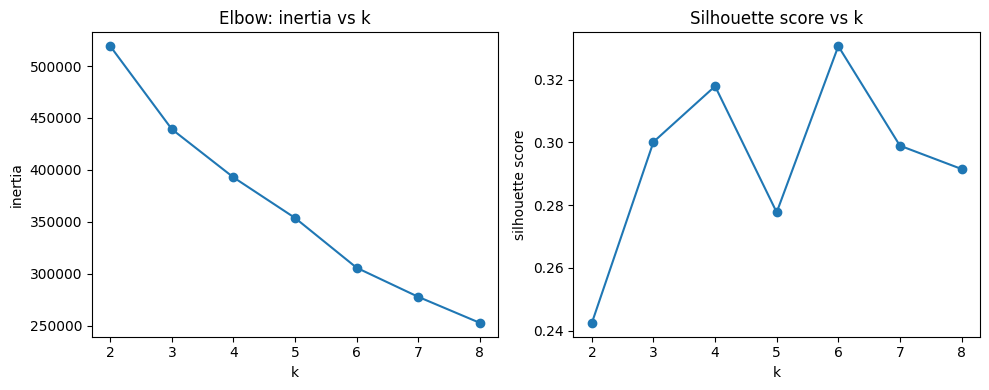

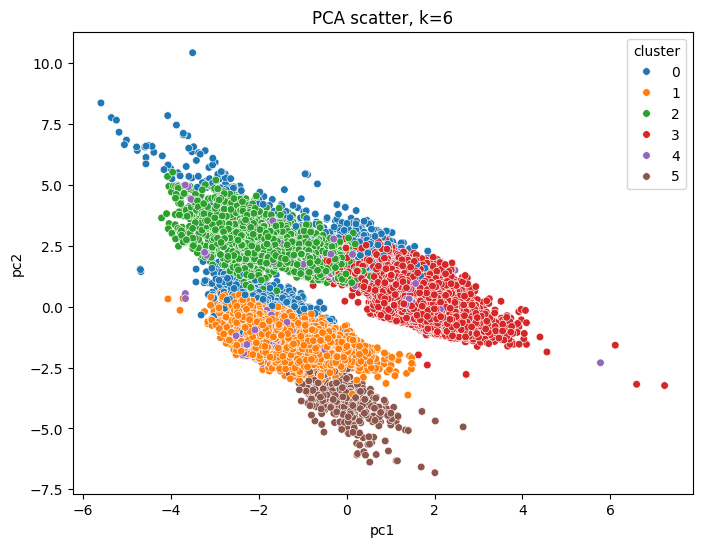

best_k = 6
         count  latitude_median  longitude_median  minimum_nights_median  \
cluster                                                                    
3        20156        40.761350        -73.979690                    3.0   
1        17981        40.687800        -73.952040                    3.0   
2         5566        40.745965        -73.891815                    2.0   
0         3669        40.720430        -73.953230                    2.0   
4         1150        40.736865        -73.950455                    1.0   
5          373        40.621540        -74.089300                    2.0   

         number_of_reviews_median  reviews_per_month_median  \
cluster                                                       
3                             3.0                      0.22   
1                             4.0                      0.29   
2                             7.0                      0.70   
0                           128.0                      3.79   
4 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn joblib
import os
import zipfile
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
try:
    from google.colab import files
    colab_env = True
except:
    colab_env = False
csv_path_candidates = [
    "/mnt/data/AB_NYC_2019.csv",
    "/content/AB_NYC_2019.csv",
    "./AB_NYC_2019.csv"
]
zip_path_candidates = [
    "/mnt/data/AB_NYC_2019.csv.zip",
    "/content/AB_NYC_2019.csv.zip",
    "./AB_NYC_2019.csv.zip"
]
csv_path = None
for p in csv_path_candidates:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    for p in zip_path_candidates:
        if os.path.exists(p):
            with zipfile.ZipFile(p, 'r') as z:
                for name in z.namelist():
                    if name.lower().endswith(".csv"):
                        z.extract(name, ".")
                        csv_path = "./" + name
                        break
            if csv_path:
                break
if csv_path is None and colab_env:
    uploaded = files.upload()
    for fn in uploaded:
        if fn.lower().endswith(".zip"):
            with zipfile.ZipFile(io.BytesIO(uploaded[fn])) as z:
                for name in z.namelist():
                    if name.lower().endswith(".csv"):
                        z.extract(name, ".")
                        csv_path = "./" + name
                        break
        elif fn.lower().endswith(".csv"):
            csv_path = fn
if csv_path is None:
    raise FileNotFoundError("AB_NYC_2019.csv not found. Upload AB_NYC_2019.csv or AB_NYC_2019.csv.zip to Colab.")
df = pd.read_csv(csv_path)
df = df.drop_duplicates().reset_index(drop=True)
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
numeric_cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
numeric_cols = [c for c in numeric_cols if c in df.columns]
categorical_cols = []
if 'room_type' in df.columns:
    categorical_cols.append('room_type')
if 'neighbourhood_group' in df.columns:
    categorical_cols.append('neighbourhood_group')
df_model = df.copy()
for col in numeric_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(df_model[col].median())
if 'price' in df_model.columns:
    df_model['price_log'] = np.log1p(df_model['price'])
    model_numeric = [c for c in numeric_cols if c!='price'] + ['price_log']
else:
    model_numeric = numeric_cols.copy()
if categorical_cols:
    df_dummies = pd.get_dummies(df_model[categorical_cols], drop_first=True)
    X = pd.concat([df_model[model_numeric].reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)
else:
    X = df_model[model_numeric].reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertia = []
sil_scores = []
K_range = range(2,9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, marker='o')
plt.title('Elbow: inertia vs k')
plt.xlabel('k')
plt.ylabel('inertia')
plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.title('Silhouette score vs k')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.tight_layout()
plt.show()
best_k = int(K_range[np.argmax(sil_scores)])
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)
df['pc1'] = pcs[:,0]
df['pc2'] = pcs[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='tab10', s=30)
plt.title(f'PCA scatter, k={best_k}')
plt.legend(title='cluster')
plt.show()
cluster_profile = df.groupby('cluster').agg({
    'id':'count'
}).rename(columns={'id':'count'})
for col in model_numeric:
    if col in df.columns:
        cluster_profile[col + '_median'] = df.groupby('cluster')[col].median()
profile_display = cluster_profile.sort_values('count', ascending=False)
print("best_k =", best_k)
print(profile_display)
if 'neighbourhood_group' in df.columns:
    neigh = df.groupby(['cluster','neighbourhood_group']).size().unstack(fill_value=0)
    print(neigh)
if 'room_type' in df.columns:
    rt = df.groupby(['cluster','room_type']).size().unstack(fill_value=0)
    print(rt)
out_csv = "clustered_listings.csv"
df.to_csv(out_csv, index=False)
model_file = "kmeans_model.joblib"
joblib.dump({'scaler':scaler, 'kmeans':kmeans, 'pca':pca, 'feature_columns': list(X.columns)}, model_file)
if colab_env:
    from google.colab import files as gfiles
    gfiles.download(out_csv)
    gfiles.download(model_file)
else:
    print("Saved files:", out_csv, model_file)


Dataset 2

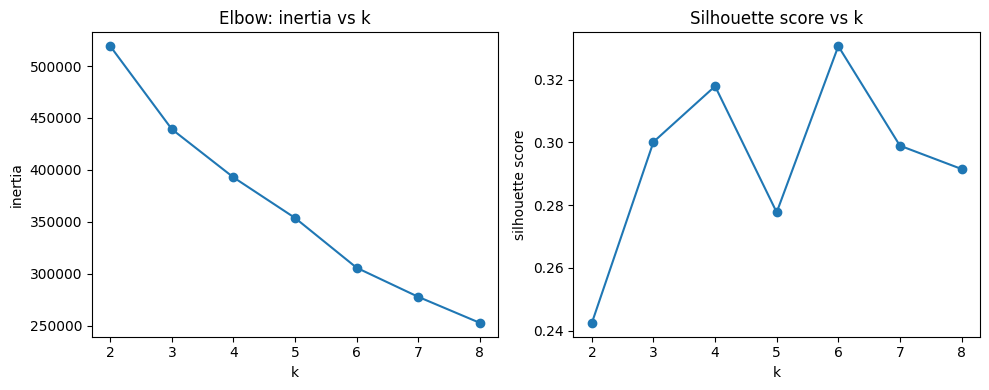

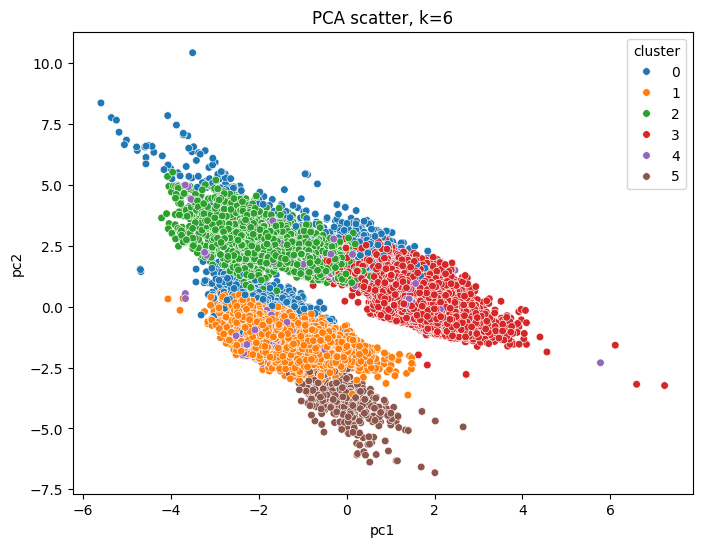

best_k = 6
         count  latitude_median  longitude_median  minimum_nights_median  \
cluster                                                                    
3        20156        40.761350        -73.979690                    3.0   
1        17981        40.687800        -73.952040                    3.0   
2         5566        40.745965        -73.891815                    2.0   
0         3669        40.720430        -73.953230                    2.0   
4         1150        40.736865        -73.950455                    1.0   
5          373        40.621540        -74.089300                    2.0   

         number_of_reviews_median  reviews_per_month_median  \
cluster                                                       
3                             3.0                      0.22   
1                             4.0                      0.29   
2                             7.0                      0.70   
0                           128.0                      3.79   
4 

Saving CA_category_id.json to CA_category_id.json
Parsed JSON categories count: 31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn joblib
import os, zipfile, io, json
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt, seaborn as sns
import joblib
try:
    from google.colab import files
    colab_env = True
except:
    colab_env = False
csv_candidates = ["/mnt/data/AB_NYC_2019.csv","/content/AB_NYC_2019.csv","./AB_NYC_2019.csv"]
zip_candidates = ["/mnt/data/AB_NYC_2019.csv.zip","/content/AB_NYC_2019.csv.zip","./AB_NYC_2019.csv.zip"]
json_candidates = ["/mnt/data/CA_category_id.json","/content/CA_category_id.json","./CA_category_id.json"]
csv_path = None
for p in csv_candidates:
    if os.path.exists(p):
        csv_path = p; break
if csv_path is None:
    for p in zip_candidates:
        if os.path.exists(p):
            with zipfile.ZipFile(p,'r') as z:
                for name in z.namelist():
                    if name.lower().endswith(".csv"):
                        z.extract(name,".")
                        csv_path = "./"+name
                        break
            if csv_path: break
if csv_path is None and colab_env:
    uploaded = files.upload()
    for fn in uploaded:
        if fn.lower().endswith(".zip"):
            with zipfile.ZipFile(io.BytesIO(uploaded[fn])) as z:
                for name in z.namelist():
                    if name.lower().endswith(".csv"):
                        z.extract(name,".")
                        csv_path = "./"+name
                        break
        elif fn.lower().endswith(".csv"):
            csv_path = fn
if csv_path is None:
    raise FileNotFoundError("AB_NYC_2019 CSV not found. Upload AB_NYC_2019.csv or AB_NYC_2019.csv.zip.")
df = pd.read_csv(csv_path)
df = df.drop_duplicates().reset_index(drop=True)
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
numeric_cols = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','availability_365']
numeric_cols = [c for c in numeric_cols if c in df.columns]
categorical_cols = []
if 'room_type' in df.columns: categorical_cols.append('room_type')
if 'neighbourhood_group' in df.columns: categorical_cols.append('neighbourhood_group')
df_model = df.copy()
for col in numeric_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(df_model[col].median())
if 'price' in df_model.columns:
    df_model['price_log'] = np.log1p(df_model['price'])
    model_numeric = [c for c in numeric_cols if c!='price'] + ['price_log']
else:
    model_numeric = numeric_cols.copy()
if categorical_cols:
    df_dummies = pd.get_dummies(df_model[categorical_cols], drop_first=True)
    X = pd.concat([df_model[model_numeric].reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)
else:
    X = df_model[model_numeric].reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertia, sil_scores = [], []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, marker='o')
plt.title('Elbow: inertia vs k')
plt.xlabel('k')
plt.ylabel('inertia')
plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.title('Silhouette score vs k')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.tight_layout()
plt.show()
best_k = int(K_range[np.argmax(sil_scores)])
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)
df['pc1'] = pcs[:,0]; df['pc2'] = pcs[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='tab10', s=30)
plt.title(f'PCA scatter, k={best_k}')
plt.legend(title='cluster')
plt.show()
cluster_profile = df.groupby('cluster').agg({'id':'count'}).rename(columns={'id':'count'})
for col in model_numeric:
    if col in df.columns:
        cluster_profile[col+'_median'] = df.groupby('cluster')[col].median()
profile_display = cluster_profile.sort_values('count', ascending=False)
print("best_k =", best_k)
print(profile_display)
if 'neighbourhood_group' in df.columns:
    neigh = df.groupby(['cluster','neighbourhood_group']).size().unstack(fill_value=0)
    print(neigh)
if 'room_type' in df.columns:
    rt = df.groupby(['cluster','room_type']).size().unstack(fill_value=0)
    print(rt)
out_csv = "clustered_listings.csv"
df.to_csv(out_csv, index=False)
model_file = "kmeans_model.joblib"
joblib.dump({'scaler':scaler,'kmeans':kmeans,'pca':pca,'feature_columns':list(X.columns)}, model_file)
json_path = None
for p in json_candidates:
    if os.path.exists(p):
        json_path = p; break
if json_path is None and colab_env:
    uploaded = files.upload()
    for fn in uploaded:
        if fn.lower().endswith(".json"):
            json_path = fn
            break
if json_path:
    with open(json_path,'r',encoding='utf-8') as f:
        j = json.load(f)
    items = j.get('items', j)
    parsed = []
    for it in items:
        snippet = it.get('snippet', {})
        parsed.append({'id': it.get('id'), 'title': snippet.get('title'), 'assignable': snippet.get('assignable')})
    parsed_file = "CA_categories_parsed.json"
    with open(parsed_file,'w',encoding='utf-8') as f:
        json.dump(parsed, f, ensure_ascii=False, indent=2)
    print("Parsed JSON categories count:", len(parsed))
else:
    parsed_file = None
if colab_env:
    from google.colab import files as gfiles
    gfiles.download(out_csv)
    gfiles.download(model_file)
    if parsed_file:
        gfiles.download(parsed_file)
else:
    print("Saved files:", out_csv, model_file, parsed_file)
